In [1]:
%%time
%matplotlib inline
from new_import import *

CPU times: user 13.6 s, sys: 4.16 s, total: 17.8 s
Wall time: 11.4 s


In [2]:
%%time
# Dask gateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,4))
dc = datacube.Datacube()

# Configure s3 access
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

client

Starting new cluster.
CPU times: user 800 ms, sys: 34.9 ms, total: 834 ms
Wall time: 4min 6s


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.09ba2acfb6f14695b1ade20816ec5742/status,


In [3]:
## cấu hình thời gian lấy ảnh và tọa độ
# date_range = ('2022-09-01', '2023-10-01')
# longtitude_range = (105.86575, 105.94120)
# latitude_range = (9.65070, 9.69850)
date_range = ('2022-09-01', '2023-10-01')
longtitude_range = (105.5, 106.4)
latitude_range = (9.2, 10.0) 

In [4]:
## truy vấn ảnh vệ tinh sen2
data = load_data(dc, date_range, longtitude_range, latitude_range)
notebook_utils.heading(notebook_utils.xarray_object_size(data))
display(data)

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 151, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [5]:
# Specify the start and end times 
min_date = '2022-09-01' # Thời gian bắt đầu lấy data cho quá trình train
max_date = '2023-10-01' # Thời gian kết thúc lấy data cho quá trình train
# Just do 1 month for testing
# max_date = '2022-10-01' # Thời gian kết thúc lấy data cho quá trình train

# Specify a spatail region to search using latitude/longitude cooridinates
min_longitude, max_longitude = (105.5, 106.4)
min_latitude, max_latitude = (9.2, 10.0)

# Specify the product. In this case we want to use Sentinel-2 Level-2A data
product = 's2_l2a'

# Construct the search query dictionary
query = {
    'product': product,                     # Product name
    'x': (min_longitude, max_longitude),    # "x" axis bounds
    'y': (min_latitude, max_latitude),      # "y" axis bounds
    'time': (min_date, max_date),           # Any parsable date strings
}

In [6]:
# Most common CRS
native_crs = notebook_utils.mostcommon_crs(dc, query)
print(f'Most common native CRS: {native_crs}')

Most common native CRS: EPSG:32648


In [7]:
# Specify the spectral band measurements we want to use for a classification algorithm
measurements = ['red', 'nir', 'scl']

load_params = {
    'measurements': measurements,                   # Selected measurement or alias names
    'output_crs': native_crs,                       # Target EPSG code
    'resolution': (-10, 10),                        # Target resolution
    'group_by': 'solar_day',                        # Scene grouping
    'dask_chunks': {'x': 2048, 'y': 2048},          # Dask chunks
}


In [8]:
%%time
# The replacement "dc.load()" function for this product
data = load_s2l2a_with_offset(
    dc,
    query | load_params   # Combine the two dicts that contain our search and load parameters
)

# This line prints the total size of the dataset hat was loaded
notebook_utils.heading(notebook_utils.xarray_object_size(data))

display(data)

No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 151, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

CPU times: user 1.57 s, sys: 177 µs, total: 1.57 s
Wall time: 1.66 s


In [9]:
# %%time
# # Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
# result = mask_clean(data)
# progress(result)

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 1.42 s, sys: 28.2 ms, total: 1.45 s
Wall time: 1.45 s


VBox()

In [10]:
# Tiến hành tính toán NDVI
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 151, y: 8874, x: 9902)>
dask.array<truediv, shape=(151, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648

In [11]:
%%time
## tính ndvi theo tháng
average_ndvi = ndvi.resample(time='1M').mean().persist()
progress(average_ndvi)

CPU times: user 678 ms, sys: 0 ns, total: 678 ms
Wall time: 677 ms


VBox()

In [12]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

In [13]:
# cấu hình vh vv file
# name_vh = "ThuanHoa/ThuanHoa_VH.tif"
# name_vv = "ThuanHoa/ThuanHoa_VV.tif"

# load dữ liệu sen1
# dsvh, dsvv = load_sen1(name_vh, name_vv)

name_vh = "vh-0922_0923-full_ST.tif"
name_vv = "vv-0922_0923-full_ST.tif"

if not os.path.exists(name_vh):
    !aws s3 cp s3://easi-asia-dc-data/staging/ctu/sentinel-1/vh-0922_0923-full_ST.tif vh-0922_0923-full_ST.tif
if not os.path.exists(name_vv):
    !aws s3 cp s3://easi-asia-dc-data/staging/ctu/sentinel-1/vv-0922_0923-full_ST.tif vv-0922_0923-full_ST.tif
    
dsvh, dsvv = load_sen1(name_vh, name_vv)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [28]:
average_ndvi = average_ndvi[:, :7680, :8687]
mask = ~np.isnan(average_ndvi)
print(average_ndvi.shape)
print(dsvh.shape)
print(dsvv.shape)
print(mask.shape)
X_train = np.stack([dsvh.values[mask], dsvv.values[mask]], axis=1)
y_train = average_ndvi.values[mask]

(13, 7680, 8687)
(13, 7680, 8687)
(13, 7680, 8687)
(13, 7680, 8687)


In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [30]:
X_pred = np.stack([dsvh.values[~mask], dsvv.values[~mask]], axis=1)
average_ndvi.values[~mask] = model.predict(X_pred)

In [31]:
average_ndvi_filled = xr.DataArray(average_ndvi, dims=average_ndvi.dims)

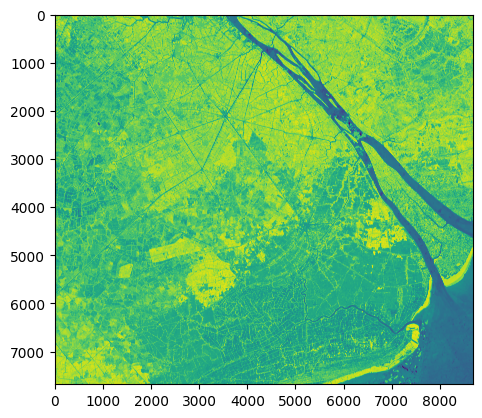

In [32]:
plt.imshow(average_ndvi_filled.isel(time=6))

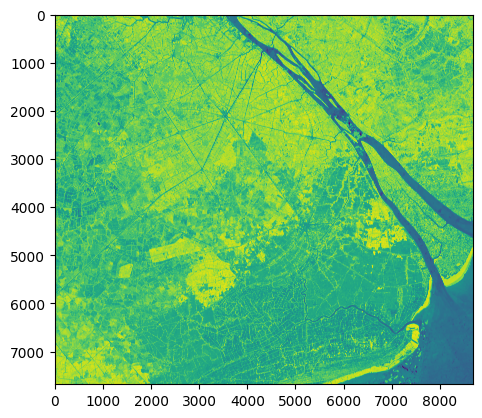

In [65]:
plt.imshow(average_ndvi.isel(time=6))

In [33]:
train_path = "train/ST_training data_updated_1130points.shp"

In [34]:
train = load_train_data(train_path)

In [37]:
datasets = get_data_sen1_and_sen2(train, average_ndvi_filled, dsvh, dsvv)

In [39]:
# cấu hình nhãn dữ liệu
label_mapping = {
    "Lua tom": "0",
    "Lua": "1",
    "CHN": "2",
    "CLN": "3",
    "TS": "4",
    "Song": "5",
    "Dat xay dung": "6",
    "Rung": "7"
}

# chia tập dữ liệu train, val, test
X_train, X_val, X_test, y_train, y_val, y_test = split_train_data(train, label_mapping, datasets)

In [40]:
# Huấn luyện mô hình
grid_search = train_with_rf(X_train, X_val, y_train, y_val)

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__n_estimators': 500}
Accuracy: 88.0 %


In [41]:
# kiểm tra độ chính xác với tập test
y_pred_test = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy for test data {round(test_accuracy, 2)*100} %")

Accuracy for test data 92.0 %


In [42]:
# Lưu mô hình huấn luyện
save_model("model_new.joblib", grid_search)

Done!


In [43]:
# đóng client, cluster
client.close()
cluster.close()